<a href="https://colab.research.google.com/github/GauraoM/Deep-Learning/blob/main/Fine_Tuning_vs_Bottleneck_VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import PIL
import zipfile

In [ ]:
# UNzip the file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
from sklearn.datasets import load_files
data_dir = "/content/sample_data/flowers"

data = load_files(data_dir)

In [ ]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

print(X)

['/content/sample_data/flowers/sunflower/7176729016_d73ff2211e.jpg'
 '/content/sample_data/flowers/dandelion/18385846351_3a2bf60427_n.jpg'
 '/content/sample_data/flowers/dandelion/98992760_53ed1d26a9.jpg' ...
 '/content/sample_data/flowers/dandelion/7184780734_3baab127c2_m.jpg'
 '/content/sample_data/flowers/sunflower/10386540106_1431e73086_m.jpg'
 '/content/sample_data/flowers/sunflower/164670176_9f5b9c7965.jpg']


In [ ]:
# Remove .pyc or .py files
pyc_file_pos = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))

for pos in pyc_file_pos:
  X = np.delete(X,pos)
  y = np.delete(y,pos)

print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0]) 

Number of training files :  4317
Number of training targets :  4317


In [ ]:
#We have only the file names in X. Time to load the images from filename and save it to X.
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
  arr = []
  for file_path in file_path_list:
    img = load_img(file_path, target_size=(224,224))
    img = img_to_array(img)
    arr.append(img)
  return arr

X = np.array(convert_img_to_arr(X))
print(X.shape)
print("first training item:",X[0])

(4317, 224, 224, 3)
first training item: [[[ 16.  18.   5.]
  [ 35.  46.  12.]
  [ 38.  49.  19.]
  ...
  [  2.  74. 124.]
  [  4.  70. 122.]
  [  6.  79. 130.]]

 [[ 44.  50.   6.]
  [ 44.  47.  16.]
  [ 26.  29.  18.]
  ...
  [  1.  82. 137.]
  [ 23.  88. 152.]
  [ 11.  70. 126.]]

 [[ 31.  39.  15.]
  [ 51.  57.  31.]
  [ 23.  32.  15.]
  ...
  [  8.  72. 116.]
  [ 21.  63. 111.]
  [ 24.  77. 121.]]

 ...

 [[114. 107.  17.]
  [164. 158.  36.]
  [109.  99.  40.]
  ...
  [ 83. 103. 130.]
  [ 86. 104. 124.]
  [ 86.  97. 115.]]

 [[ 76.  74.  15.]
  [167. 149.  21.]
  [117. 103.  40.]
  ...
  [ 83. 101. 125.]
  [ 80.  98. 122.]
  [ 80.  95. 118.]]

 [[196. 172.  46.]
  [157. 152.  24.]
  [165. 145.  22.]
  ...
  [ 28.  30.  25.]
  [ 45.  55.  57.]
  [ 61.  74.  83.]]]


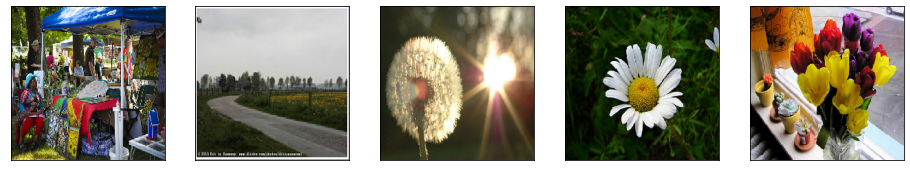

In [ ]:
# Lets see first 5 training data
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))

In [ ]:
# Rescale within 0-1
X = X.astype('float32')/255

In [ ]:
X[0]

array([[[0.0627451 , 0.07058824, 0.01960784],
        [0.13725491, 0.18039216, 0.04705882],
        [0.14901961, 0.19215687, 0.07450981],
        ...,
        [0.00784314, 0.2901961 , 0.4862745 ],
        [0.01568628, 0.27450982, 0.47843137],
        [0.02352941, 0.30980393, 0.50980395]],

       [[0.17254902, 0.19607843, 0.02352941],
        [0.17254902, 0.18431373, 0.0627451 ],
        [0.10196079, 0.11372549, 0.07058824],
        ...,
        [0.00392157, 0.32156864, 0.5372549 ],
        [0.09019608, 0.34509805, 0.59607846],
        [0.04313726, 0.27450982, 0.49411765]],

       [[0.12156863, 0.15294118, 0.05882353],
        [0.2       , 0.22352941, 0.12156863],
        [0.09019608, 0.1254902 , 0.05882353],
        ...,
        [0.03137255, 0.28235295, 0.45490196],
        [0.08235294, 0.24705882, 0.43529412],
        [0.09411765, 0.3019608 , 0.4745098 ]],

       ...,

       [[0.44705883, 0.41960785, 0.06666667],
        [0.6431373 , 0.61960787, 0.14117648],
        [0.42745098, 0

In [ ]:
# Lets confirm no. of classes
no_of_classes = len(np.unique(y))
no_of_classes

5

In [ ]:
# Perform one hot encoding
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y, no_of_classes))
y[0]

array([0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
# Lets divide into training, validation and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_test.shape[0]

864

In [ ]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
X_valid.shape[0]

432

#### Fine tunning

In [ ]:
from keras.models import Model
from keras import optimizers
from tensorflow.keras import applications
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout 
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

#load the VGG16 model without the final layers(include_top=False)
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False)
print('Loaded Model!')

#Let's freeze the first 15 layers - if you see the VGG model layers below, 
# we are freezing till the last Conv layer.
for layer in base_model.layers[:15]:
  layer.trainable = False

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Loaded Model!
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                

In [ ]:
# Now, let's create a top_model to put on top of the base model
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
top_model.add(Dense(no_of_classes, activation='softmax')) 
top_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Let's build the final model where we add the top_model on top of base_model.
model = Sequential()
model.add(base_model)
model.add(top_model)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 sequential_2 (Sequential)   (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Train the model

epochs=20
batch_size=32
best_model_finetuned_path = 'best_finetuned_model.hdf5'

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

validation_generator = test_datagen.flow(X_valid, y_valid, batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_path, save_best_only=True,verbose=1) # Save the weights

history = model.fit_generator(
          train_generator,
          steps_per_epoch = len(X_train)//batch_size,
          epochs = epochs,
          validation_data = validation_generator,
          validation_steps = len(X_valid)//batch_size,
          callbacks = [checkpointer]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 1.5831 - accuracy: 0.3005
Epoch 1: val_loss improved from inf to 1.45101, saving model to best_finetuned_model.hdf5
107/107 [==============================] - 61s 431ms/step - loss: 1.5831 - accuracy: 0.3005 - val_loss: 1.4510 - val_accuracy: 0.4447
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 1.3437 - accuracy: 0.5145
Epoch 2: val_loss improved from 1.45101 to 1.18862, saving model to best_finetuned_model.hdf5
107/107 [==============================] - 45s 415ms/step - loss: 1.3437 - accuracy: 0.5145 - val_loss: 1.1886 - val_accuracy: 0.5913
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 1.0833 - accuracy: 0.6288
Epoch 3: val_loss improved from 1.18862 to 0.91802, saving model to best_finetuned_model.hdf5
107/107 [==============================] - 44s 407ms/step - loss: 1.0833 - accuracy: 0.6288 - val_loss: 0.9180 - val_accuracy: 0.6947
Epoch 4/20
107/107 [============

In [ ]:
model.load_weights(best_model_finetuned_path) # Load the weights

(eval_loss, eval_accuracy) = model.evaluate(
                                            X_test,
                                            y_test,
                                            verbose = 1
                                            )

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

14/14 [==============================] - 4s 269ms/step - loss: 0.3972 - accuracy: 0.8611
Accuracy: 86.11%
Loss: 0.3972429633140564


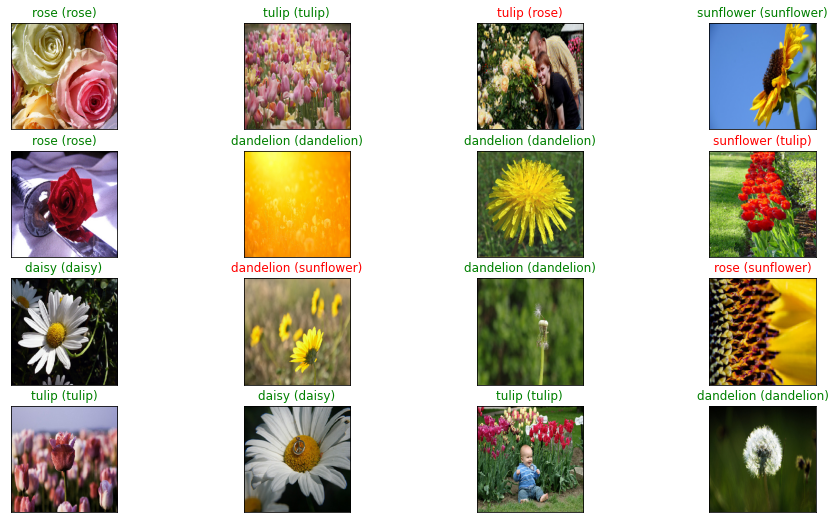

In [ ]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
  # Plot
  fig = plt.figure(figsize=(16,9))
  for i, idx in enumerate(np.random.choice(X_test.shape[0],size=16,replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color = "green" if pred_idx == true_idx else "red")
    
visualize_pred(model.predict(X_test))

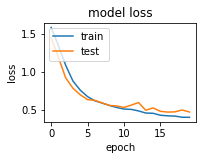

In [ ]:
import matplotlib.pyplot as plt 
# Let's visualize the loss and accuracy wrt epochs
def plot(history):
    plt.figure(1)  

     # summarize history for accuracy  

    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  

   # summarize history for loss
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'],loc='upper left')
    plt.show()

plot(history)

In [ ]:
import math

epochs = 20
batch_size = 32

model = applications.VGG16(weights="imagenet", include_top=False)

datagen = ImageDataGenerator()

generator = datagen.flow(
            X_train,
            batch_size = batch_size,
            shuffle = False
)
# Predict generator gives us the probability
train_data = model.predict_generator(generator, int(math.ceil(len(X_train)/ batch_size)))

print(train_data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


(3453, 7, 7, 512)


In [ ]:
# For validation 
generator = datagen.flow(
            X_valid,
            batch_size = batch_size,
            shuffle = False
)
# Predict generator gives us the probability
validation_data = model.predict_generator(generator, int(math.ceil(len(X_valid)/ batch_size)))

print(validation_data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


(432, 7, 7, 512)


In [ ]:
# For Test 
generator = datagen.flow(
            X_test,
            batch_size = batch_size,
            shuffle = False
)
# Predict generator gives us the probability
test_data = model.predict_generator(generator, int(math.ceil(len(X_test)/ batch_size)))

print(test_data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


(432, 7, 7, 512)


In [ ]:
from keras.layers import GlobalAveragePooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

best_model_bottleneck_path = 'best_bottleneck_model.hdf5'

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(no_of_classes,activation="softmax"))

model.compile(optimizer="rmsprop",loss="categorical_crossentropy",metrics=['accuracy'])

checkpointer = ModelCheckpoint(best_model_bottleneck_path,save_best_only = True,verbose = 1)

history = model.fit(train_data, y_train,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, y_valid),
          callbacks =[checkpointer]) 

Epoch 1/20
104/108 [===========================>..] - ETA: 0s - loss: 1.4293 - accuracy: 0.4462
Epoch 1: val_loss improved from inf to 1.21971, saving model to best_bottleneck_model.hdf5
108/108 [==============================] - 1s 7ms/step - loss: 1.4235 - accuracy: 0.4500 - val_loss: 1.2197 - val_accuracy: 0.6157
Epoch 2/20
100/108 [==========================>...] - ETA: 0s - loss: 1.1352 - accuracy: 0.6419
Epoch 2: val_loss improved from 1.21971 to 1.03145, saving model to best_bottleneck_model.hdf5
108/108 [==============================] - 1s 5ms/step - loss: 1.1304 - accuracy: 0.6426 - val_loss: 1.0314 - val_accuracy: 0.6806
Epoch 3/20
 97/108 [=========================>....] - ETA: 0s - loss: 0.9787 - accuracy: 0.6956
Epoch 3: val_loss improved from 1.03145 to 0.91992, saving model to best_bottleneck_model.hdf5
108/108 [==============================] - 1s 6ms/step - loss: 0.9766 - accuracy: 0.6936 - val_loss: 0.9199 - val_accuracy: 0.6968
Epoch 4/20
106/108 [==================

In [ ]:
model.load_weights(best_model_bottleneck_path)  
   
(test_loss, test_accuracy) = model.evaluate(  
     test_data, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("Loss: {}".format(test_loss))

14/14 [==============================] - 0s 5ms/step - loss: 0.5098 - accuracy: 0.8287
Accuracy: 82.87%
Loss: 0.5098337531089783


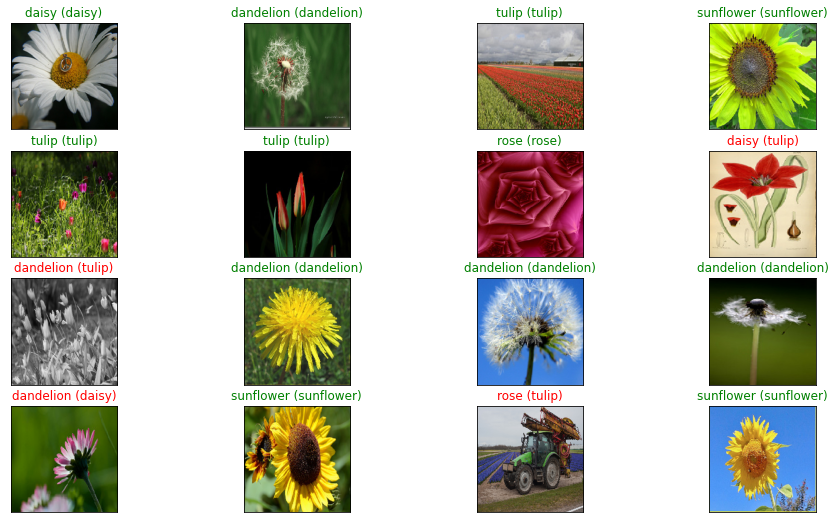

In [ ]:
# Let's visualize some random test prediction.
visualize_pred(model.predict(test_data))

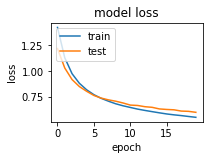

In [ ]:
plot(history)

In [ ]:
from keras.models import Model
from keras import optimizers

base_model = applications.VGG16(weights="imagenet", include_top=False)

best_model_finetuned_bottleneck = "best_bottleneck_finetuned_model.hdf5"

# Freezing layers
for layer in base_model.layers[:15]:
  layer.trainable = False

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(no_of_classes,activation="softmax"))

# loading the weights of bottle neck features model
# loading the weights of bottle neck features model
top_model.load_weights(best_model_bottleneck_path)

model = Sequential()
model.add(base_model)
model.add(top_model)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 sequential_2 (Sequential)   (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

validation_generator = test_datagen.flow(X_valid, y_valid, batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_bottleneck, save_best_only=True,verbose=1)

history = model.fit_generator(
          train_generator,
          steps_per_epoch = len(X_train)//batch_size,
          epochs = 20,
          validation_data = validation_generator,
          validation_steps = len(X_valid)//batch_size,
          callbacks = [checkpointer]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
107/107 [==============================] - ETA: 0s - loss: 0.5242 - accuracy: 0.8129
Epoch 1: val_loss improved from inf to 0.52071, saving model to best_bottleneck_finetuned_model.hdf5
107/107 [==============================] - 45s 414ms/step - loss: 0.5242 - accuracy: 0.8129 - val_loss: 0.5207 - val_accuracy: 0.8269
Epoch 2/20
107/107 [==============================] - ETA: 0s - loss: 0.4536 - accuracy: 0.8346
Epoch 2: val_loss improved from 0.52071 to 0.49709, saving model to best_bottleneck_finetuned_model.hdf5
107/107 [==============================] - 44s 407ms/step - loss: 0.4536 - accuracy: 0.8346 - val_loss: 0.4971 - val_accuracy: 0.8269
Epoch 3/20
107/107 [==============================] - ETA: 0s - loss: 0.4129 - accuracy: 0.8547
Epoch 3: val_loss improved from 0.49709 to 0.43323, saving model to best_bottleneck_finetuned_model.hdf5
107/107 [==============================] - 43s 405ms/step - loss: 0.4129 - accuracy: 0.8547 - val_loss: 0.4332 - val_accuracy: 0.8558

In [ ]:
model.load_weights(best_model_finetuned_bottleneck)  
   
(test_loss, test_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(test_accuracy * 100))  
print("Loss: {}".format(test_loss))

14/14 [==============================] - 2s 152ms/step - loss: 0.2655 - accuracy: 0.9005
Accuracy: 90.05%
Loss: 0.2654550075531006
